In [1]:
import pandas as pd
import numpy as np
from buckaroo.buckaroo_widget import BuckarooWidget

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
df = pd.read_csv('/Users/paddy/code/citibike-play/2014-01 - Citi Bike trip data.csv')
BuckarooWidget(df[:10_000])

In [ ]:
def sample(df, sample_size=500, include_outliers=True):
    
    sample_size = np.min([sample_size, len(df)])
    sdf = df.sample(sample_size)
    
    
    if include_outliers:
        outlier_idxs = []
        for col in df.columns:
            idxs = df[col].sort_values().index
            outlier_idxs.extend(idxs[:5])
            outlier_idxs.extend(idxs[-5:])
        outlier_idxs.extend(sdf.index)
        uniq_idx = np.unique(outlier_idxs)
        #print(uniq_idx)
        return df.iloc[uniq_idx]
    return sdf


In [ ]:
%timeit sample(df, 500)

In [ ]:
%timeit sample(df, 10)

In [ ]:
%timeit sample(df, 5000)

In [ ]:
len(sample(df))

In [ ]:
df.iloc[[23,58, 1023]]

In [ ]:
import numpy as np

In [ ]:
df = pd.read_csv('./examples/data/2014-01-citibike-tripdata.csv')
w = BuckarooWidget(df)
w

In [ ]:
ab = df['tripduration']
ab.sort_values()

In [ ]:
sorted_ab = ab.sort_values()
sorted_ab.index[:5]

In [ ]:
import numpy as np

In [ ]:
np.unique([2,2,3])

In [ ]:
df['start station name'].sort_values()

In [ ]:
np.array([2,2,3]).unique()

In [ ]:
a = []
a.extend([23,45], [32,5])
a

In [ ]:
df.columns

In [ ]:
bc = df.sample(300)

In [ ]:
bc.index

In [ ]:
arr = [2,3]
arr.extend(df.index)

In [ ]:
df.iloc[[137, 137, 138]]

In [ ]:
pd.concat([df.iloc[sorted_ab.index[:5]], df[20:50]])

In [ ]:
from buckaroo.all_transforms import Command
from buckaroo.lispy import s
#Here we start adding commands to the Buckaroo Widget.  Every call to add_command replaces a command with the same name
@w.add_command
class GroupBy2(Command):
    command_default = [s("groupby2"), s('df'), 'col', {}]
    command_pattern = [[3, 'colMap', 'colEnum', ['null', 'sum', 'mean', 'median', 'count']]]
    @staticmethod 
    def transform(df, col, col_spec):
        grps = df.groupby(col)
        df_contents = {}
        for k, v in col_spec.items():
            if v == "sum":
                df_contents[k] = grps[k].apply(lambda x: x.sum())
            elif v == "mean":
                df_contents[k] = grps[k].apply(lambda x: x.mean())
            elif v == "median":
                df_contents[k] = grps[k].apply(lambda x: x.median())
            elif v == "count":
                df_contents[k] = grps[k].apply(lambda x: x.count())
        return pd.DataFrame(df_contents)

    @staticmethod 
    def transform_to_py(df, col, col_spec):
        commands = [
            "    grps = df.groupby('%s')" % col,
            "    df_contents = {}"
        ]
        for k, v in col_spec.items():
            if v == "sum":
                commands.append("    paddydf_contents['%s'] = grps['%s'].apply(lambda x: x.sum())" % (k, k))
            elif v == "mean":
                commands.append("    df_contents['%s'] = grps['%s'].apply(lambda x: x.mean())" % (k, k))
            elif v == "median":
                commands.append("    df_contents['%s'] = grps['%s'].apply(lambda x: x.median())" % (k, k))
            elif v == "count":
                commands.append("    df_contents['%s'] = grps['%s'].apply(lambda x: x.count())" % (k, k))
        commands.append("    df = pd.DataFrame(df_contents)")
        return "\n".join(commands)


In [2]:
np.random.rand(1,100)[0]

array([0.98543491, 0.88189975, 0.8519125 , 0.34405232, 0.64923551,
       0.76498397, 0.08317026, 0.33898759, 0.8959272 , 0.84532194,
       0.61846565, 0.97065402, 0.33760845, 0.14928914, 0.46931127,
       0.44402314, 0.3851214 , 0.30878261, 0.15215036, 0.30283917,
       0.34619956, 0.94479008, 0.52277332, 0.46966805, 0.01990334,
       0.0090225 , 0.18186927, 0.67424679, 0.38775559, 0.48266829,
       0.83345845, 0.7639416 , 0.71366249, 0.40440437, 0.0687034 ,
       0.99350699, 0.02384897, 0.61694475, 0.16986129, 0.76552384,
       0.49479425, 0.50517121, 0.80248113, 0.38342123, 0.25053957,
       0.09369322, 0.53027412, 0.80884121, 0.96754405, 0.10643695,
       0.30732228, 0.09244387, 0.75280274, 0.66100238, 0.21485027,
       0.74945128, 0.45370822, 0.88729706, 0.18465771, 0.01511092,
       0.13943961, 0.68186614, 0.68525074, 0.90057088, 0.58703984,
       0.47070748, 0.85631468, 0.48696279, 0.94382412, 0.91341682,
       0.85296105, 0.05317179, 0.68182398, 0.13682457, 0.43423

In [5]:
np.random.random_sample(5)

array([0.12371643, 0.27411337, 0.44275076, 0.21505491, 0.57833314])

<Axes: >

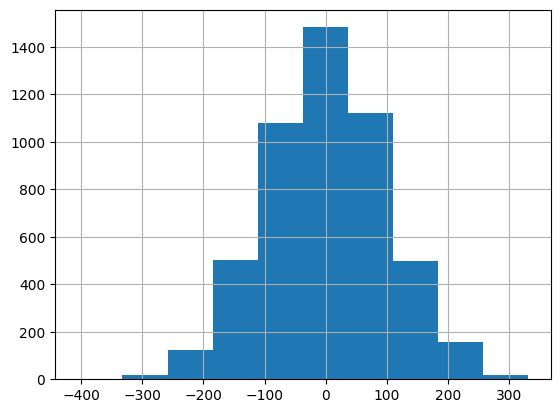

In [28]:
arr = np.random.standard_normal(5000) * 100
arr = arr.astype(int)
ser = pd.Series(arr)
ser.hist()

In [29]:
populations, endpoints = np.histogram(arr, 10)
populations

array([   3,   17,  124,  501, 1079, 1483, 1123,  497,  156,   17])

In [32]:
endpoints

array([-406. , -332.3, -258.6, -184.9, -111.2,  -37.5,   36.2,  109.9,
        183.6,  257.3,  331. ])

In [38]:
def histogram_labels(endpoints):
    left = endpoints[0]
    labels = []
    for edge in endpoints[1:]:
        labels.append("%d   %d" % (left, edge))
        left = edge
    return labels
histogram_labels(endpoints)

['-406   -332',
 '-332   -258',
 '-258   -184',
 '-184   -111',
 '-111   -37',
 '-37   36',
 '36   109',
 '109   183',
 '183   257',
 '257   331']

In [42]:
normalized_pop = populations / populations.sum()
normalized_pop

array([0.0006, 0.0034, 0.0248, 0.1002, 0.2158, 0.2966, 0.2246, 0.0994,
       0.0312, 0.0034])

In [44]:
dict(zip( histogram_labels(endpoints), normalized_pop))

{'-406   -332': 0.0006,
 '-332   -258': 0.0034,
 '-258   -184': 0.0248,
 '-184   -111': 0.1002,
 '-111   -37': 0.2158,
 '-37   36': 0.2966,
 '36   109': 0.2246,
 '109   183': 0.0994,
 '183   257': 0.0312,
 '257   331': 0.0034}

In [45]:
def histogram_formatted_dict(arr):
    populations, endpoints = np.histogram(arr, 10)
    labels = histogram_labels(endpoints)
    normalized_pop = populations / populations.sum()
    ret_histo = []
    for label, pop in zip(labels, normalized_pop):
        ret_histo.append({'name': label, 'population':pop})
    return ret_histo
histogram_formatted_dict(arr)

[{'name': '-406   -332', 'population': 0.0006},
 {'name': '-332   -258', 'population': 0.0034},
 {'name': '-258   -184', 'population': 0.0248},
 {'name': '-184   -111', 'population': 0.1002},
 {'name': '-111   -37', 'population': 0.2158},
 {'name': '-37   36', 'population': 0.2966},
 {'name': '36   109', 'population': 0.2246},
 {'name': '109   183', 'population': 0.0994},
 {'name': '183   257', 'population': 0.0312},
 {'name': '257   331', 'population': 0.0034}]